In [1]:
import pandas as pd
import pickle
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_regression
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

**Plan:**

1. Import SelectKBest and scoring functions
2. Add method to DataPreprocessor to analyze features
3. Visualize results using matplotlib
4. Return top K features with their scores


In [2]:
class DataPreprocessor:
    NUMERICAL_COLS = [
        "age",
        "duration",
        "acousticness",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "time_signature",
        "explicit",
    ]

    def __init__(
        self,
        test_size=0.2,
        random_state=42,
        max_artist_features=3995,
        max_genre_features=21,
        max_music_features=5784,
    ):
        self.test_size = test_size
        self.random_state = random_state
        self.gender_encoder = LabelEncoder()  # Changed to LabelEncoder
        self.gender_encoder = LabelEncoder()
        self.artist_tfidf_vectorizer = TfidfVectorizer(max_features=max_artist_features)
        self.genre_tfidf_vectorizer = TfidfVectorizer(max_features=max_genre_features)
        self.music_tfidf_vectorizer = TfidfVectorizer(max_features=max_music_features)
        self.release_year_encoder = OrdinalEncoder()  # Added release year encoder
        self.scaler = StandardScaler()

    def load_data(self, filepath):
        """
        Load data from a CSV file.

        Args:
            filepath (str): Path to the CSV file.

        Returns:
            pd.DataFrame: Loaded data.
        """
        data = pd.read_csv(filepath)
        return data

    def hash_user_id(self, user_id):
        """
        Convert user_id to 32-dimensional numeric tensor.
        Returns zero vector for null/empty values.
        """
        # Handle null/empty values
        if pd.isna(user_id) or str(user_id).strip() == "":
            return np.zeros(32)

        # Hash valid user_id
        hash_hex = hashlib.md5(str(user_id).encode()).hexdigest()

        # Convert hex string to 32 integers (2 chars per integer)
        try:
            return np.array([int(hash_hex[i : i + 2], 16) for i in range(0, 64, 2)])
        except ValueError:
            # Return zero vector if conversion fails
            return np.zeros(32)

    def fit(self, data):
        """Fit all preprocessors on training data"""
        self.gender_encoder.fit(data["gender"])
        self.release_year_encoder.fit(data["release_year"])
        self.artist_tfidf_vectorizer.fit(data["artist_name"])
        self.genre_tfidf_vectorizer.fit(data["genre"])
        self.music_tfidf_vectorizer.fit(data["music"])
        self.scaler.fit(data[self.NUMERICAL_COLS])
        return self

    def transform(self, data, is_training=False):
        """Transform data using fitted preprocessors"""
        transform_fn = lambda enc, x: (
            enc.fit_transform(x) if is_training else enc.transform(x)
        )

        data_encoded = pd.DataFrame(
            {
                "user_id_hashed": np.vstack(data["user_id"].apply(self.hash_user_id)),
                "gender_encoded": transform_fn(self.gender_encoder, data["gender"]),
                "release_year_encoded": transform_fn(
                    self.release_year_encoder, data["release_year"]
                ),
            }
        )

        # Add other transformations...
        return data_encoded

    def encode_features_train(self, data):
        # Hash user IDs to 32-dim vectors
        user_id_hashed = np.vstack(data["user_id"].apply(self.hash_user_id))

        # Encode gender
        data["gender_encoded"] = self.gender_encoder.fit_transform(data["gender"])

        # Reshape release_year to 2D array and encode
        release_year_2d = data["release_year"].values.reshape(-1, 1)
        data["release_year_encoded"] = self.release_year_encoder.fit_transform(
            release_year_2d
        ).ravel()

        # Rest of the method remains the same...
        # TF-IDF Encoding
        artist_tfidf = self.artist_tfidf_vectorizer.fit_transform(data["artist_name"])
        genre_tfidf = self.genre_tfidf_vectorizer.fit_transform(data["genre"])
        music_tfidf = self.music_tfidf_vectorizer.fit_transform(data["music"])

        # Get actual feature names from vectorizers
        artist_feature_names = [
            f"artist_tfidf_{i}" for i in range(artist_tfidf.shape[1])
        ]
        genre_feature_names = [f"genre_tfidf_{i}" for i in range(genre_tfidf.shape[1])]
        music_feature_names = [f"music_tfidf_{i}" for i in range(music_tfidf.shape[1])]

        # Create DataFrames with actual dimensions
        artist_tfidf_df = pd.DataFrame(
            artist_tfidf.toarray(), columns=artist_feature_names
        )
        genre_tfidf_df = pd.DataFrame(
            genre_tfidf.toarray(), columns=genre_feature_names
        )
        music_tfidf_df = pd.DataFrame(
            music_tfidf.toarray(), columns=music_feature_names
        )

        # Combine all features in the expected order
        numerical_features = [
            "age",
            "duration",
            "acousticness",
            "danceability",
            "energy",
            "key",
            "loudness",
            "mode",
            "speechiness",
            "instrumentalness",
            "liveness",
            "valence",
            "tempo",
            "time_signature",
            "explicit",
        ]

        data_encoded = pd.DataFrame(
            {
                "user_id_hashed": list(user_id_hashed),
                "gender_encoded": data["gender_encoded"],
                "release_year_encoded": data["release_year_encoded"],
            }
        )

        data_encoded = pd.concat(
            [
                data_encoded,
                music_tfidf_df,
                artist_tfidf_df,
                genre_tfidf_df,
                data[numerical_features],
            ],
            axis=1,
        )

        # Verify release_year exists
        if "release_year" not in data.columns:
            raise ValueError("release_year column missing from input data")

        # Add release year check after encoding
        if "release_year_encoded" not in data_encoded.columns:
            raise ValueError("release_year_encoded not properly created")

        return data_encoded

    def encode_features_transform(self, data):
        """Transform test/inference data."""
        # Hash user IDs to 32-dim vectors
        user_id_hashed = np.vstack(data["user_id"].apply(self.hash_user_id))

        # Encode gender and release year
        data["gender_encoded"] = self.gender_encoder.transform(data["gender"])

        # Reshape release_year to 2D array and encode
        release_year_2d = data["release_year"].values.reshape(-1, 1)
        data["release_year_encoded"] = self.release_year_encoder.transform(
            release_year_2d
        ).ravel()

        # TF-IDF Encoding
        artist_tfidf = self.artist_tfidf_vectorizer.transform(data["artist_name"])
        genre_tfidf = self.genre_tfidf_vectorizer.transform(data["genre"])
        music_tfidf = self.music_tfidf_vectorizer.transform(data["music"])

        # Get actual feature names from vectorizers
        artist_feature_names = [
            f"artist_tfidf_{i}" for i in range(artist_tfidf.shape[1])
        ]
        genre_feature_names = [f"genre_tfidf_{i}" for i in range(genre_tfidf.shape[1])]
        music_feature_names = [f"music_tfidf_{i}" for i in range(music_tfidf.shape[1])]

        # Create DataFrames with actual dimensions
        artist_tfidf_df = pd.DataFrame(
            artist_tfidf.toarray(), columns=artist_feature_names
        )
        genre_tfidf_df = pd.DataFrame(
            genre_tfidf.toarray(), columns=genre_feature_names
        )
        music_tfidf_df = pd.DataFrame(
            music_tfidf.toarray(), columns=music_feature_names
        )

        # Combine all features in the expected order
        numerical_features = [
            "age",
            "duration",
            "acousticness",
            "danceability",
            "energy",
            "key",
            "loudness",
            "mode",
            "speechiness",
            "instrumentalness",
            "liveness",
            "valence",
            "tempo",
            "time_signature",
            "explicit",
        ]

        data_encoded = pd.DataFrame(
            {
                "user_id_hashed": list(user_id_hashed),
                "gender_encoded": data["gender_encoded"],
                "release_year_encoded": data["release_year_encoded"],
            }
        )

        data_encoded = pd.concat(
            [
                data_encoded,
                music_tfidf_df,
                artist_tfidf_df,
                genre_tfidf_df,
                data[numerical_features],
            ],
            axis=1,
        )

        # Verify release_year exists
        if "release_year" not in data.columns:
            raise ValueError("release_year column missing from input data")

        # Add release year check after encoding
        if "release_year_encoded" not in data_encoded.columns:
            raise ValueError("release_year_encoded not properly created")

        return data_encoded

    def feature_engineering(self, data_encoded):
        """Scale numerical features and normalize plays"""
        numerical_features = [
            "age",
            "duration",
            "acousticness",
            "danceability",
            "energy",
            "key",
            "loudness",
            "mode",
            "speechiness",
            "instrumentalness",
            "liveness",
            "valence",
            "tempo",
            "time_signature",
            "explicit",
        ]

        # Store plays separately before scaling
        target = None
        if "plays" in data_encoded.columns:
            target = data_encoded["plays"]
            # Add log transformation for skewed play counts
            target = np.log1p(target)  # Add 1 and take log
            # Then normalize
            target = (target - target.min()) / (target.max() - target.min())

        # Scale numerical features
        data_encoded[numerical_features] = self.scaler.fit_transform(
            data_encoded[numerical_features]
        )

        # Add normalized plays back
        if target is not None:
            data_encoded["plays"] = target

        return data_encoded

    def split_data(self, data_encoded, target_column="plays", val_size=0.1):
        features = data_encoded.drop(columns=[target_column])
        target = data_encoded[target_column]

        # Handle duplicate values in binning
        try:
            bins = pd.qcut(target, q=10, labels=False, duplicates="drop")
        except ValueError:
            # Fallback if too many duplicates
            bins = pd.cut(target, bins=10, labels=False)

        # Split with stratification
        train_features, temp_features, train_target, temp_target = train_test_split(
            features,
            target,
            test_size=self.test_size + val_size,
            random_state=self.random_state,
            stratify=bins,
        )

        # Further split temp into validation and test
        val_features, test_features, val_target, test_target = train_test_split(
            temp_features,
            temp_target,
            test_size=self.test_size / (self.test_size + val_size),
            random_state=self.random_state,
            stratify=pd.qcut(temp_target, q=5, labels=False, duplicates="drop"),
        )

        return (
            train_features,
            val_features,
            test_features,
            train_target,
            val_target,
            test_target,
        )

    def save_preprocessors(self, directory="models/"):
        """Save all preprocessors including release year encoder"""
        preprocessors = {
            "gender_encoder": self.gender_encoder,
            "artist_tfidf_vectorizer": self.artist_tfidf_vectorizer,
            "genre_tfidf_vectorizer": self.genre_tfidf_vectorizer,
            "music_tfidf_vectorizer": self.music_tfidf_vectorizer,
            "release_year_encoder": self.release_year_encoder,
            "scaler": self.scaler,
        }

        for name, preprocessor in preprocessors.items():
            with open(f"{directory}{name}.pkl", "wb") as f:
                pickle.dump(preprocessor, f)

    def load_preprocessors(self, directory="models/"):
        """Load all preprocessors including release year encoder"""
        preprocessors = {
            "gender_encoder": "gender_encoder.pkl",
            "artist_tfidf_vectorizer": "artist_tfidf_vectorizer.pkl",
            "genre_tfidf_vectorizer": "genre_tfidf_vectorizer.pkl",
            "music_tfidf_vectorizer": "music_tfidf_vectorizer.pkl",
            "release_year_encoder": "release_year_encoder.pkl",
            "scaler": "scaler.pkl",
        }

        for attr, filename in preprocessors.items():
            with open(f"{directory}{filename}", "rb") as f:
                setattr(self, attr, pickle.load(f))

    def analyze_feature_importance(self, data_encoded, target, k=10):
        """
        Analyze and visualize the K most important features using f_regression.
        
        Args:
            data_encoded: DataFrame of encoded features
            target: Series of target values (plays)
            k: Number of top features to select
        """
        # Remove non-numeric columns and target
        feature_cols = data_encoded.select_dtypes(include=['float64', 'int64']).columns
        X = data_encoded[feature_cols]
        
        # Initialize and fit SelectKBest
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X, target)
        
        # Get scores and feature names
        scores = pd.DataFrame({
            'Feature': feature_cols,
            'Score': selector.scores_
        }).sort_values('Score', ascending=False)
        
        # Plot top K features
        plt.figure(figsize=(12, 6))
        sns.barplot(data=scores.head(k), x='Score', y='Feature')
        plt.title(f'Top {k} Features by F-Regression Score')
        plt.tight_layout()
        plt.show()
        
        return scores.head(k)

    def analyze_class_distribution(self, target, n_bins=5, plot=True):
        """
        Analyze and visualize target distribution with proper binning
        """
        try:
            # Try qcut first
            try:
                bins = pd.qcut(
                    target, 
                    q=n_bins, 
                    labels=[f'Bin {i+1}' for i in range(n_bins)],
                    duplicates='drop'
                )
            except ValueError:
                # Fallback to cut if qcut fails
                bins = pd.cut(
                    target,
                    bins=n_bins,
                    labels=[f'Bin {i+1}' for i in range(n_bins)]
                )
            
            distribution = Counter(bins)
            
            if plot:
                plt.figure(figsize=(10, 6))
                sns.countplot(x=bins)
                plt.title('Target Variable Distribution (Plays)')
                plt.xlabel('Play Count Bins')
                plt.ylabel('Frequency')
                plt.xticks(rotation=45)
                
                # Add value labels on bars
                for i, v in enumerate(distribution.values()):
                    plt.text(i, v, str(v), ha='center', va='bottom')
                
                plt.tight_layout()
                plt.show()
                
            # Calculate and display statistics    
            max_class = max(distribution.values())
            min_class = min(distribution.values())
            imbalance_ratio = max_class / min_class
            
            print("\nDistribution Statistics:")
            print(f"Total samples: {len(target)}")
            print(f"Imbalance ratio: {imbalance_ratio:.2f}")
            print("\nBin Ranges:")
            
            # Get bin edges without accessing categories
            bin_edges = pd.IntervalIndex(bins.unique()).to_tuples()
            for i, (lower, upper) in enumerate(bin_edges):
                print(f"Bin {i+1}: ({lower:.2f}, {upper:.2f}]")
                
            return distribution
            
        except Exception as e:
            print(f"Error analyzing distribution: {str(e)}")
            return None

    def balance_classes(self, X, y, method='smote', sampling_strategy='auto'):
        """Balance classes using SMOTE or undersampling"""
        if method.lower() == 'smote':
            sampler = SMOTE(sampling_strategy=sampling_strategy)
        else:
            sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
            
        X_resampled, y_resampled = sampler.fit_resample(X, y)
        return X_resampled, y_resampled

    def inspect_tfidf_features(self, feature_name='music'):
        """Inspect TF-IDF vectorizer features"""
        vectorizer = getattr(self, f'{feature_name}_tfidf_vectorizer')
        
        # Get vocabulary and feature names
        vocab = vectorizer.vocabulary_
        feature_names = vectorizer.get_feature_names_out()
        
        print(f"\n{feature_name.title()} TF-IDF Features:")
        print(f"Total features: {len(feature_names)}")
        print(f"Max features setting: {vectorizer.max_features}")
        print("\nTop 10 features by vocabulary index:")
        for word, idx in sorted(vocab.items(), key=lambda x: x[1])[:10]:
            print(f"{word}: {idx}")
        
        return vocab, feature_names

# Usage example:
"""
preprocessor = DataPreprocessor()
data = preprocessor.load_data("your_data.csv")

# Check class distribution
distribution = preprocessor.analyze_class_distribution(data['plays'])

# Balance classes if needed
X_resampled, y_resampled = preprocessor.balance_classes(
    data_encoded, 
    data['plays'],
    method='smote'
)

# Inspect TF-IDF features
vocab, features = preprocessor.inspect_tfidf_features('music')
"""

'\npreprocessor = DataPreprocessor()\ndata = preprocessor.load_data("your_data.csv")\n\n# Check class distribution\ndistribution = preprocessor.analyze_class_distribution(data[\'plays\'])\n\n# Balance classes if needed\nX_resampled, y_resampled = preprocessor.balance_classes(\n    data_encoded, \n    data[\'plays\'],\n    method=\'smote\'\n)\n\n# Inspect TF-IDF features\nvocab, features = preprocessor.inspect_tfidf_features(\'music\')\n'

In [3]:
# Initialize the preprocessor
preprocessor = DataPreprocessor(
test_size=0.2,
random_state=42,
max_artist_features=3995,
max_genre_features=21,
max_music_features=5784
)

# Load and preprocess data
filepath = "../data/cleaned_modv2.csv"

# In main function, add error handling for data loading
try:
    data = preprocessor.load_data(filepath)
except Exception as e:
    print(f"Error loading data from {filepath}: {e}")



In [4]:
data = preprocessor.load_data(filepath)
data.head()

,user_id,age,gender,music,artist_name,featured_artists,genre,plays,duration,music_id,...,speechiness,instrumentalness,liveness,valence,tempo,time_signature,release_date,explicit,age_group,release_year
0,83811,16,F,Bank Account,21 Savage,"Birdy, Zoé",Dark Trap,11,3.67,2fQrGHiQOvpL9UgPvtYy6G,...,0.351000,0.000007,0.087100,0.376000,75.016000,4.0,2017-09-23,True,Gen Z,2017
1,83811,16,F,Little Talks,Of Monsters and Men,"Ninho, Snoop Dogg, Russ, Paramore",Unknown,686,4.44,2ihCaVdNZmnHZWt0fvAM7B,...,0.032200,0.000000,0.284500,0.413000,101.890500,4.0,2013-04-12,False,Gen Z,2013
2,13397,17,M,Wherever I Go,OneRepublic,"Keith Urban, DJ Khaled, NIKI, MF DOOM",Unknown,136,2.83,46jLy47W8rkf8rEX04gMKB,...,0.089400,0.043432,0.273133,0.404183,120.850500,4.0,2009-02-03,False,Gen Z,2009
3,70645,44,M,No New Friends,DJ Khaled,"The xx, LIT killah",Pop,230,5.14,5oVlbbiKGdGeZkWCFy0mqk,...,0.167000,0.000000,0.096600,0.400000,109.283000,4.0,2017-01-01,False,Gen X,2017
4,70645,44,M,Dreams,Campsite Dream,NaN,Country,391,3.20,1SNoSoQ3JZldOhzBY9gw0n,...,0.078837,0.235527,0.180354,0.380815,120.488479,4.0,1974,False,Gen X,1974


In [5]:
# aggregate plays by song for each user
import pandas as pd
from io import StringIO

# Reading data into a DataFrame
df = data.copy()

# Aggregating plays by song
aggregated_plays = df.groupby('music')['plays'].sum().reset_index()

# Output the result
print(aggregated_plays)


                                  music  plays
0                                 $TING    419
1                       'Round Midnight      1
2                            'Til I Die    416
3               (Don't Fear) The Reaper    937
4     (Everything I Do) I Do It For You   1150
...                                 ...    ...
9465                              waves      1
9466                           way back    237
9467                          wonderful   1046
9468                           Équinoxe      1
9469                       멘붕 - CL SOLO    348

[9470 rows x 2 columns]


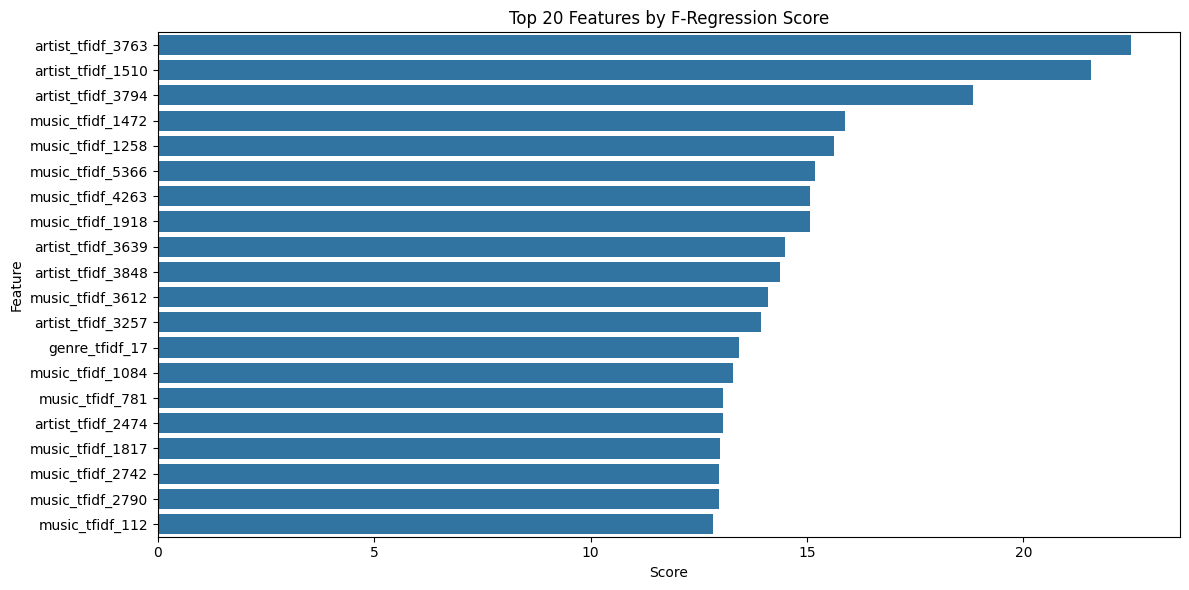

                Feature      Score
9549  artist_tfidf_3763  22.495923
7296  artist_tfidf_1510  21.557032
9580  artist_tfidf_3794  18.829841
1474   music_tfidf_1472  15.884158
1260   music_tfidf_1258  15.616670
5368   music_tfidf_5366  15.184807
4265   music_tfidf_4263  15.071087
1920   music_tfidf_1918  15.071087
9425  artist_tfidf_3639  14.502412
9634  artist_tfidf_3848  14.386872
3614   music_tfidf_3612  14.110201
9043  artist_tfidf_3257  13.937847
9798     genre_tfidf_17  13.439331
1086   music_tfidf_1084  13.279106
783     music_tfidf_781  13.067167
8260  artist_tfidf_2474  13.067167
1819   music_tfidf_1817  12.986108
2744   music_tfidf_2742  12.969926
2792   music_tfidf_2790  12.969926
114     music_tfidf_112  12.828647


In [6]:
preprocessor = DataPreprocessor()
filepath = "../data/cleaned_modv2.csv"
data = preprocessor.load_data(filepath)
data_encoded = preprocessor.encode_features_train(data)
top_features = preprocessor.analyze_feature_importance(
    data_encoded, 
    data['plays'], 
    k=20
)
print(top_features)

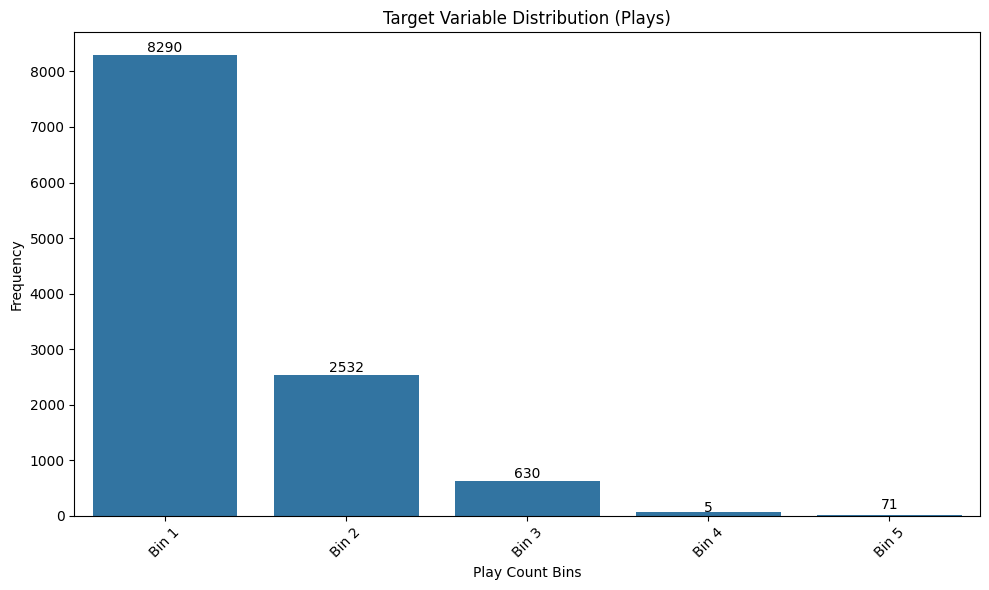


Distribution Statistics:
Total samples: 11528
Imbalance ratio: 1658.00

Bin Ranges:
Error analyzing distribution: type <class 'str'> with value Bin 1 is not an interval


ValueError: setting an array element with a sequence.

In [ ]:
preprocessor = DataPreprocessor()
data = preprocessor.load_data(filepath)

# Encode features
data_encoded = preprocessor.encode_features_train(data)

# Check class distribution
distribution = preprocessor.analyze_class_distribution(data['plays'])

# Balance classes if needed
X_resampled, y_resampled = preprocessor.balance_classes(
    data_encoded, 
    data['plays'],
    method='smote'
)

# Inspect TF-IDF features
vocab, features = preprocessor.inspect_tfidf_features('music')

In [46]:
distribution = preprocessor.analyze_class_distribution(
    data['plays'],
    n_bins=10
)

Error in binning: Bin labels must be one fewer than the number of bin edges
Attempting alternative binning strategy...


AssertionError: 

In [7]:
vocab, features = preprocessor.inspect_tfidf_features('music')



Music TF-IDF Features:
Total features: 5784
Max features setting: 5784

Top 10 features by vocabulary index:
000: 0
00000: 1
10: 2
100: 3
1000: 4
1005: 5
101: 6
104: 7
11: 8
112: 9


In [ ]:
# inspect all tfidf features
feature_names = ['genre','music','artist']
vocab_features = [preprocessor.inspect_tfidf_features(feature_name) for feature_name in feature_names]
vocab, features  = zip(*vocab_features)


Genre TF-IDF Features:
Total features: 21
Max features setting: 21

Top 10 features by vocabulary index:
acoustic: 0
blues: 1
christian: 2
classical: 3
country: 4
dance: 5
easy: 6
electronic: 7
emo: 8
folk: 9

Music TF-IDF Features:
Total features: 5784
Max features setting: 5784

Top 10 features by vocabulary index:
000: 0
00000: 1
10: 2
100: 3
1000: 4
1005: 5
101: 6
104: 7
11: 8
112: 9

Artist TF-IDF Features:
Total features: 3995
Max features setting: 3995

Top 10 features by vocabulary index:
10: 0
11: 1
112: 2
182: 3
1975: 4
21: 5
22: 6
24: 7
2am: 8
2cellos: 9
